<h3>Imports and classes</h3>

In [1]:
# load required packages
# coding: utf-8
%matplotlib inline
import os
import sys
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
import collections
from statistics import mean
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
# Sklearn imports
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split


from sklearn.metrics import *

from sklearn.feature_selection import VarianceThreshold

# Different machine learning models from sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score

CWD = os.getcwd()
RANDOMSTATE = 42

class IuPred:
    '''
    Needs description.
    '''    
    def __init__(self, glob, short, long):
        self.glob = glob
        self.short = short
        self.long = long


class HydroPhobicIndex:
    '''
    Needs description.
    '''
    def __init__(self, hpilist):
        self.hpilist = hpilist

/usr/local/lib64/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# note: the iupred2a package has to be manually downloaded and placed in a reachable directory of choice

<h3>Functions</h3>

In [4]:
# define functions required to train the machine learning classifier
def preprocess_data(df, scaler):
    info = df.select_dtypes(include=['object'])
    y = df[instance]
    X = df.drop([instance], axis=1)
    X = X._get_numeric_data()
    columns = X.columns
    
    X = scaler.fit_transform(X)    
    X = pd.DataFrame(X, columns=columns)
    X[instance] = y
    X = X.merge(info, how='outer', left_index=True, right_index=True)    
    return X


def remove_correlating_features(df, cutoff=.95, plot=False):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    print('Correlation: Features before %s' % df.shape[1])
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    # Drop features
    df = df.drop(to_drop, axis=1)
    
    
    print('Correlation: Features after %s' % df.shape[1])
    if plot:
        # Plot heatmap
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(data=df.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1)
        plt.savefig(os.getcwd()+ '\\data\graphs\\6.Heatmap_after_correlation.pdf', transparent=True)
        plt.show()
    return df


def varianceSelection(df, threashold=.8):
    if not isinstance(df, pd.core.frame.DataFrame):
        logger.error('[%s] : [ERROR] Variance selection only possible on Dataframe not %s',
                                     datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'), type(df))
        sys.exit(1)
    sel = VarianceThreshold(threshold=(threashold * (1 - threashold)))
    sel.fit_transform(df)
    return df[[c for (s, c) in zip(sel.get_support(), df.columns.values) if s]]


def filter_low_variance(df, non_feature_columns, variance_cutoff=.8):
    df_variancetreshold = varianceSelection(df.drop(non_feature_columns, axis=1), variance_cutoff)
    for col in non_feature_columns:
        df_variancetreshold[col] = df[col]
    return df_variancetreshold


def remove_low_variance_features(df, variance_cutoff, plot=False):
    print('Low varience: Features before %s' % df.shape[1])
    non_feature_columns = ['protein_name', 'sequence', 'llps']
    df_variance = filter_low_variance(df, non_feature_columns, variance_cutoff)
    print('Low varience: Features after  %s' % df_variance.shape[1])
    
    # Set matplotlib parameters
    if plot:
        sns.set(rc={'figure.figsize':(8,6)})
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42

        # Plot heatmap
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(data=df_variance.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1)

        plt.savefig(os.getcwd()+ '\\data\graphs\\6.heatmap_after_low_variance.pdf', transparent=True)
        plt.show()
    return df_variance


def get_feature_importances(df, clf):
    '''
    Needs description.
    '''    
    fi = clf.feature_importances_
    fi = pd.DataFrame(fi).transpose()
    fi.columns = df.columns[1:]
    fi = fi.melt()
    fi = fi.sort_values('value', ascending=False)
    fi = fi.loc[fi['value'] > 0.0]
    return fi


def select_testing_data(df, instance, ratio=1, info_columns=['protein_name', 'sequence'], random=False):
    '''
    Class that equalizes the data based on the number of positives.
    :param df: dataframe with all the features and instance
    :param instance: string of instance columns
    :param ratio: ratio of how many negatives should be added (2 = twice as much negative)
    :param random: bool which gives a random test set with both instances randomly picked.
    :return: 'out' dataframe with new data, and 'df_info' dataframe with the information of 
    protein name and sequence.
    '''
    pos = df.loc[df[instance] == 1]
    neg_index = df.loc[df[instance] == 0].index
    negsubset_index = sample(set(neg_index), len(pos) * ratio)
    if random:
        possubset_index = sample(set(df.index), len(pos))
        negsubset_index = sample(set(df.index), len(pos))
        pos = df.loc[possubset_index]
        pos[instance] = pos[instance] = 1
    neg = df.loc[negsubset_index]
    out = pos.append(neg)
    out = out.reset_index(drop=True)
    df_info = out[info_columns]
    out = out.drop(labels=info_columns, axis=1)
    return out, df_info


def calculate_performance(clf, X_test, y_test):
    '''
    Needs description.
    '''    
    prediction = clf.predict(X_test)
    correctness = prediction == y_test
    distribution = correctness.value_counts(True)
    return distribution


def train_model(data, clf, instance):
    df, df_info = select_testing_data(data, instance, ratio=1, random=False)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(instance, axis=1),
                                                        df[instance],
                                                        test_size=0.5,
                                                        random_state=RANDOMSTATE,
                                                        )
    clf = clf.fit(X_train, y_train)
    return clf, X_test, y_test

    
def plot_pca(df, title='', analysis_name=''):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(['sequence', 'protein_name'],axis=1))
    pca_df = pd.DataFrame(X_pca, columns=['component1', 'component2'])
    pca_df['protein_name'] = df['protein_name']
    pca_df['llps'] = df.reset_index()['llps']


    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 0],
                    x = 'component1',
                    y = 'component2',
                    alpha = .5,
                    color = '#AEB6BF',
                    rasterized=True,
                   )
    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#CD6155',                
                   )
    
    
    # print(pca_df.loc[(pca_df['llps'] == 1) & (pca_df['component1'] >= 650)])
    
    plt.ylabel('Component1 (' + str(round(pca.explained_variance_ratio_[0] * 100, 2)) + '%)')
    plt.xlabel('Component2 (' + str(round(pca.explained_variance_ratio_[1] * 100, 2)) + '%)')
    plt.title(title)
    plt.savefig(os.getcwd()+ f'\\analysis\\{analysis_name}\\PCA_plot.pdf', transparent=True)
    plt.show()


def average(l):
    return sum(l) / len(l)

<h1>1. Data processing and feature selection </h1>

In [5]:
# data preprocessing
def preprocess_and_scaledata(data, instance):
    try:
        data = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id', 'PRDaa'], axis=1)
    except KeyError:
        data = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id'], axis=1)
    data = data.fillna(value=0)
    print(data.shape)
    print('Number of phase separating proteins in dataset: '+str(data.loc[data[instance] == 1].shape[0]))
    print(data.shape)
    
    # scaler = QuantileTransformer(output_distribution='normal')
    scaler = QuantileTransformer()
    df = data.copy()
    processed_data = df.fillna(0)
    processed_data = preprocess_data(processed_data, scaler)
    #processed_data = remove_correlating_features(processed_data, cutoff=.95)
    #processed_data = remove_low_variance_features(processed_data, variance_cutoff=0.08)
    return processed_data

In [7]:
# could be required depending on package versions used. If the error: name 'pickle' not defined shows up, than 
# importing pickle5 as pickle provides a suitable workaround
import pickle5 as pickle

In [8]:
# load : get the data from file
data = pickle.load(open("/path/to/output/from/workbook2.pkl", "rb"))

In [9]:
# data filtering to take out very small (<100 AAs) and very big (> 3000 AAs) proteins and
# define some things
instance = 'llps'
data = data.loc[(data['length'] >= 100) & (data['length'] <= 3000)]
data = data.reset_index(drop=True)
domain_cols = data.columns[data.columns.str.contains("^domain")]
domain_data = data[domain_cols]
data.drop(columns=domain_cols)
data = preprocess_and_scaledata(data, instance)

(19504, 96)
Number of phase separating proteins in dataset: 90
(19504, 96)


# Test method

In [11]:
class EnsembleRandomForest:
    def __init__(self):
        self.estimators = list()

    def fit(self, data, index_list, label):
        estimators=list()   
        non_numeric_columns = (list(data.select_dtypes(include='object')))
        data = data.select_dtypes([np.number])
        for index in tqdm(index_list):
            df = data.loc[index]
            X = df.drop(instance, axis=1)
            y = df[label]
            clf = RandomForestClassifier()
            clf.fit(X, y)
            estimators.append(clf)
        self.estimators = estimators

    def predict_proba(self, df, label):
        probabilities = list()
        for clf in self.estimators:
            probability = clf.predict_proba(df)[:,1]
            probabilities.append(probability)
        probabilities = np.array(probabilities)
        predictions = list()
        for i in range(probabilities.shape[1]):
            prediction = np.average(probabilities[:,i])
            predictions.append(prediction)
        return predictions

In [12]:
def split_dataframe_data(data, label, n=30, n_negative=30):
    positive_label_sample = data[data[label] == 1].sample(n)
    negative_label_sample = data[data[label] == 0].sample(n_negative)
    train_data = data.drop(list(positive_label_sample.index))
    train_data = train_data.drop(list(negative_label_sample.index))
    test_data = shuffle(positive_label_sample.append(negative_label_sample)).reset_index(drop=True)      
    return train_data, test_data,

### K-Fold cross validation

Updated: 
* Now uses `StratifiedKfold` for better selection of positives/negatives per fold.
* 10-fold cross-validation.


In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
label = 'llps'
data_filtered = data.select_dtypes([np.number])
X = data_filtered.drop(label, axis=1)
y = data_filtered[label]
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

 10%|█         | 1/10 [00:07<01:10,  7.81s/it]

Fold 1 ROC AUC: 0.8552


 20%|██        | 2/10 [00:15<01:00,  7.61s/it]

Fold 2 ROC AUC: 0.7379


 30%|███       | 3/10 [00:22<00:53,  7.58s/it]

Fold 3 ROC AUC: 0.9053


 40%|████      | 4/10 [00:30<00:45,  7.62s/it]

Fold 4 ROC AUC: 0.9567


 50%|█████     | 5/10 [00:38<00:38,  7.67s/it]

Fold 5 ROC AUC: 0.9043


 60%|██████    | 6/10 [00:45<00:30,  7.67s/it]

Fold 6 ROC AUC: 0.9057


 70%|███████   | 7/10 [00:53<00:23,  7.70s/it]

Fold 7 ROC AUC: 0.8791


 80%|████████  | 8/10 [01:01<00:15,  7.65s/it]

Fold 8 ROC AUC: 0.8565


 90%|█████████ | 9/10 [01:08<00:07,  7.62s/it]

Fold 9 ROC AUC: 0.9126


100%|██████████| 10/10 [01:16<00:00,  7.64s/it]

Fold 10 ROC AUC: 0.9207


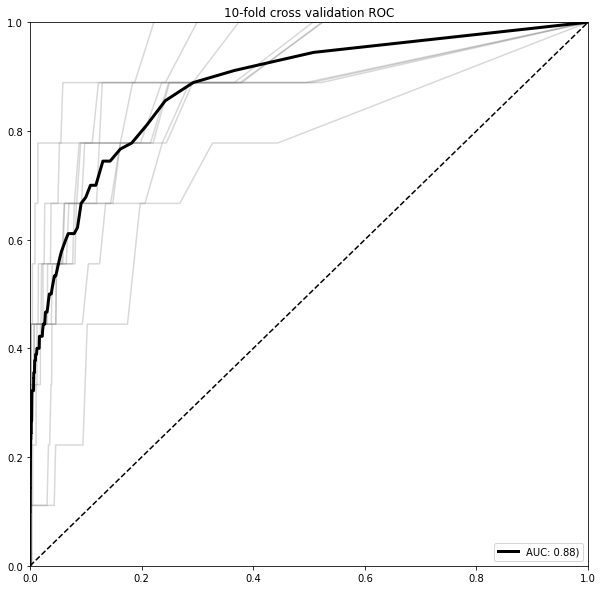

In [15]:
# perform training and generate ROC curve
clf = RandomForestClassifier(n_jobs=32, class_weight="balanced", n_estimators=1200, criterion="entropy")
#clf = XGBClassifier(n_jobs=24, scale_pos_weight)
all_y_test = list()
all_y_proba = list()
all_idx = list()
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)  
all_aucs = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X, y)), total=kf.n_splits):
    all_idx.extend(test_index)
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    #print(y_train.head())
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    # scores individual
    fpr, tpr, _ = roc_curve(y_test, y_proba)
     
    
    all_y_test.extend(y_test)
    all_y_proba.extend(y_proba)
    
    roc_auc = auc(fpr, tpr)
    print(f"Fold {i + 1} ROC AUC: {roc_auc:.4f}")
    all_aucs.append(roc_auc)
  
    plt.plot(fpr, tpr, color="grey", alpha=0.3)
        
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
    
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.2f})', color="black", lw=3)

plt.title(f'{kf.n_splits}-fold cross validation ROC')    
plt.plot([0, 1], [0, 1], 'k--')
ax.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#print("Mean AUC", np.mean(all_aucs))

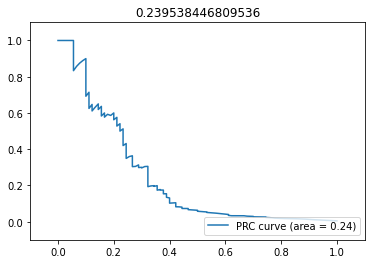

In [16]:
# plot precision recall curve
ax = plt.subplot(111)
average_precision = average_precision_score(all_y_test, all_y_proba)
precision, recall, _ = precision_recall_curve(all_y_test, all_y_proba)

plt.title('Precision Recall Curve')
ax.plot(recall, precision, label=f'PRC curve (area = {round(average_precision,2)})')
plt.title(str(average_precision))

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
ax.legend(loc="lower right")


# Train final model

And predict values for complete proteome.

In [17]:
clf = RandomForestClassifier(n_jobs=32, class_weight="balanced", n_estimators=1200, criterion="entropy", random_state=42)
clf.fit(X, y)
psap_prediction = pd.DataFrame(index=data["protein_name"])
psap_prediction["PSAP_score"] = clf.predict_proba(X)[:,1]

psap_prediction["llps"] = y.values
psap_prediction["rank"] = 0  
rank = psap_prediction.loc[psap_prediction["llps"] == 0, "PSAP_score"].rank(ascending=False)
psap_prediction["rank"] = rank

In [ ]:
# Final prediction values can be found in the psap_prediction dataframe
psap_prediction.head

In [19]:
# check some example proteins
psap_prediction.loc[["FXR2_HUMAN", "ILF3_HUMAN", "YBOX1_HUMAN", "THOC4_HUMAN", "TFG_HUMAN"]]

,PSAP_score,llps,rank
protein_name,,,
FXR2_HUMAN,0.072500,0,12.0
ILF3_HUMAN,0.053333,0,27.0
YBOX1_HUMAN,0.057500,0,23.5
THOC4_HUMAN,0.078333,0,6.0
TFG_HUMAN,0.033333,0,86.0


<h1>4. Use method to predict phase separating proteins</h1>

<h3>4.1 Prediction of the second proteome</h3>

In [29]:
def predict_proteome(df, clf, instance, testing_size, feature_imp=True, remove_training=False, second_df=pd.DataFrame()):
    pd.set_option('mode.chained_assignment', None)    
    prediction = df.select_dtypes(include='object')
    df = df.select_dtypes([np.number])
    if len(second_df) > 0:
        prediction = second_df.select_dtypes(include='object')
        second_df = second_df.select_dtypes([np.number]) 
    indexes = get_test_train_indexes(df, instance)
    count = 0  
    fi_data = None
    for index in tqdm(indexes):
        df_fraction = df.loc[index]        
    # Also consider X_test index for prediction in the proteome    
        X = df_fraction.drop(instance, axis=1)        
        y = df_fraction[instance]
        clf.fit(X, y)           
    # Feature importance
        if feature_imp:        
            #X = df_fraction.drop('llps', axis=1)
            fi = clf.feature_importances_
            fi = pd.DataFrame(fi).transpose()
            fi.columns = X.columns
            fi = fi.melt()
            fi = fi.sort_values('value', ascending=False) 
            if fi_data is None:
                fi_data = fi            
            else:
                fi_data = pd.merge(fi_data, fi, on='variable')  
    # Make prediction
        if len(second_df) > 0:
            probability = clf.predict_proba(second_df.drop(instance, axis=1))[:, 1]
            prediction['probability_'+str(count)] = probability
        else:
            probability = clf.predict_proba(df.drop(instance, axis=1))[:, 1]  
            prediction['probability_'+str(count)] = probability        
    # Removing prediction that were used in the train test set.
        if remove_training:
            for i in index:
                prediction.loc[i, 'probability_'+str(count)] = np.nan        
        count += 1
    if feature_imp:
        return prediction , fi_data
    else:
        return prediction

<h3>4.1.1 Predict proteome with RF</h3>

In [46]:
# load : load a .pkl file with sequences of interest
# important: this file has to be processed through workbook 1 and 2 as well
second_df = pickle.load(open("/path/to/second/proteome/defined/in/workbook1and2.pkl", "rb"))

In [31]:
def preprocess_and_scaledata2(data, instance):
    try:
        df2 = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id', 'PRDaa'], axis=1)
    except KeyError:
        df2 = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id'], axis=1)
    df2 = data.fillna(value=0)
    print(df2.shape)
    print('Number of phase separating proteins in dataset: '+str(data.loc[df2[instance] == 1].shape[0]))
    print(df2.shape)
    
    # scaler = QuantileTransformer(output_distribution='normal')
    scaler = QuantileTransformer()
    df2 = df2.fillna(0)
    df2 = preprocess_data(df2, scaler)
    #processed_data = remove_correlating_features(processed_data, cutoff=.95)
    #processed_data = remove_low_variance_features(processed_data, variance_cutoff=0.08)
    return df2


In [47]:
df2 = preprocess_and_scaledata2(second_df, instance)

(20381, 99)
Number of phase separating proteins in dataset: 91
(20381, 99)


In [48]:
# make column names consistent
df2 = df2.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id'], axis=1)
# data2 = data.drop(['domain RNA Binding','domain Zinc finger','domain Other'], axis=1) # only if domain analyses was done


In [42]:
# Predict second df. This will predict the input file a total of 216 times. 
# first dataframe is the one generated above and is called 'data'
# the second dataframe (the one to be predicted) is called df2

prediction, fi_data = predict_proteome(data,
                                       clf,
                                       instance='llps',
                                       testing_size=.2,
                                       # remove_training=True,
                                       second_df=df2,
                                      )

100%|██████████| 216/216 [23:29<00:00,  6.53s/it]


In [44]:
# export prediction values. 
# the average value of the 216 columns represent the final predicted probability
prediction.to_csv('/path/to/output_predictions.csv')